# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
seed = 42

Using TensorFlow backend.


In [2]:

# DATA_DIR = '/home/ritesh/Desktop/Codes/Data Process/ER_PR/extracted_patches/ER_PR_ALL/train'

# load repo with data if it is not exists
# if not os.path.exists(DATA_DIR):
#     print('Loading data...')
#     os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
#     print('Done!')

In [3]:
# X_train, X_test, y_train, y_test = train_test_split(x_dir, y_dir, test_size=0.33, random_state=42)

In [4]:
# x_dir = os.path.join(DATA_DIR, 'trainimages/')
# y_dir = os.path.join(DATA_DIR, 'trainlabels/')
TRAIN_DIR = '/home/ritesh/hdd1/vikram/ER_PR/ep_aug_all/train/'

x_train_dir = os.path.join(TRAIN_DIR, 'images/')
y_train_dir = os.path.join(TRAIN_DIR, 'labels/')

VAL_DIR = '/home/ritesh/hdd1/vikram/ER_PR/ep_aug_all/val/'
x_valid_dir = os.path.join(VAL_DIR, 'images/')
y_valid_dir = os.path.join(VAL_DIR, 'labels/')

# TEST_DIR = '/media/ritesh/119940757D37B1B4/ritesh/ER_PR_data/ER_PR_POS/test/'
# TEST_DIR = '/home/ritesh/Desktop/Codes/Data Process/ER_PR/extracted_patches/ER_PR_ALL/test'
TEST_DIR = '/home/ritesh/hdd1/vikram/ER_PR/extracted_patches/test'

x_test_dir = os.path.join(TEST_DIR, 'images/')
y_test_dir = os.path.join(TEST_DIR, 'labels/')

In [5]:
len(glob(x_valid_dir+'*'))

900

# Dataloader and utility functions 

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
#     CLASSES = ['strong','moderate','weak','no stain']
    CLASSES = ['moderate','weak']

    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
#             mode=None
    ):
#         x_train, x_val, y_train, y_val = train_test_split(sorted(os.listdir(images_dir)), sorted(os.listdir(masks_dir)), test_size=0.2, random_state=42)
        
#         if mode == 'train':
#         self.ids = os.listdir(images_dir)
        self.ids = [x for x in os.listdir(images_dir) if x.endswith(".png")]
        self.mask_ids = [x for x in os.listdir(images_dir) if x.endswith(".png")]
#         elif mode == 'val':
#             self.ids = x_val
#             self.mask_ids = y_val
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower())+1 for cls in classes]
#         self.class_values = [1,2,3,4]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
#         print('Image Dir: ',self.images_fps[i])
        image = cv2.imread(self.images_fps[i])
#         print('Image Shape:', image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.
        mask = cv2.imread(self.masks_fps[i], 0)
#         mask = np.load(self.masks_fps[i])[:,:,0]
                
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((background, mask), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

(256, 256, 3)
(256, 256, 3)


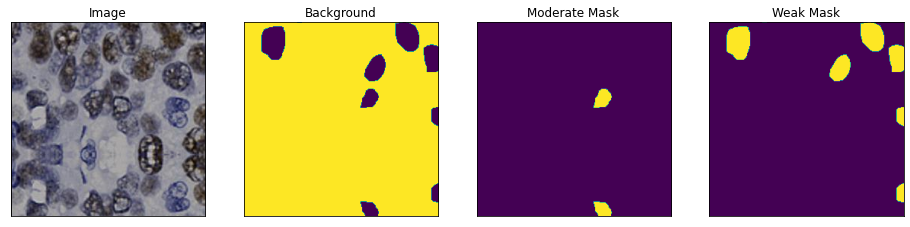

In [7]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['moderate', 'weak'])

image, mask = dataset[31040] # get some sample
print(image.shape)
print(mask.shape)
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    moderate_mask=mask[..., 1].squeeze(),
    weak_mask=mask[..., 2].squeeze(),
#     No_stain_mask=mask[..., 3].squeeze(),
#     background_mask=mask[..., 4].squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [8]:
import albumentations as A

In [9]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [10]:
# # Lets look at augmented data we have
# dataset = Dataset(x_train_dir, y_train_dir, classes=['strong', 'moderate'], augmentation=get_training_augmentation(),mode='train')

# image, mask = dataset[12]# get some sample
# print(image.shape)
# visualize(
#     image=image, 
#     cars_mask=mask[..., 0].squeeze(),
#     sky_mask=mask[..., 1].squeeze(),
#     background_mask=mask[..., 2].squeeze(),
# )

# Segmentation model training

In [11]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [12]:
# BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['moderate','weak']
LR = 0.0001
EPOCHS = 10

# preprocess_input = sm.get_preprocessing(BACKBONE)

In [13]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'


In [14]:
#create model
from multiResUnet import MultiResUnet
model = MultiResUnet((256,256,3), n_classes=n_classes, activation=activation)

Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Respath
Conv: (1, 1)
Conv: (3, 3)
Conv: (1, 1)
Conv: (3, 3)
Conv: (1, 1)
Conv: (3, 3)
Conv: (1, 1)
Conv: (3, 3)
Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Respath
Conv: (1, 1)
Conv: (3, 3)
Conv: (1, 1)
Conv: (3, 3)
Conv: (1, 1)
Conv: (3, 3)
Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Respath
Conv: (1, 1)
Conv: (3, 3)
Conv: (1, 1)
Conv: (3, 3)
Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Respath
Conv: (1, 1)
Conv: (3, 3)
Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Multiresblock
Conv: (1, 1)
Conv: (3, 3)
Conv: (5, 5)
Conv: (7, 7)
Conv: (1, 1)


In [15]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([1.0,1.0,1.0]))
jaccard_loss = sm.losses.JaccardLoss(class_weights=np.array([1.0,2.0,2.0]))
categorical_crossentropy = sm.losses.CategoricalCELoss(class_weights=np.array([0.5, 1.0, 1.0]))
#focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()

total_loss = jaccard_loss + (1 * categorical_crossentropy)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [16]:
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [17]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
#     augmentation=get_training_augmentation(),
#     preprocessing=get_preprocessing(preprocess_input),
#     mode='train'
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(preprocess_input),
#     mode='val'
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     keras.callbacks.ModelCheckpoint('./models/model_pos_1.h5', save_weights_only=True, save_best_only=True, mode='min'),
#     keras.callbacks.ReduceLROnPlateau(),
# ]
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.ModelCheckpoint('./models/multiResUnet_mw_all.h5', verbose=1, save_best_only=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
1798/4546 [==========>...................] - ETA: 11:15:25 - loss: 0.9383 - iou_score: 0.2524 - f1-score: 0.3333

In [ ]:
# # train model
# history = model.fit_generator(
#     train_dataloader, 
#     steps_per_epoch=len(train_dataloader), 
#     epochs=40, 
#     callbacks=callbacks, 
#     validation_data=valid_dataloader, 
#     validation_steps=len(valid_dataloader),
# )

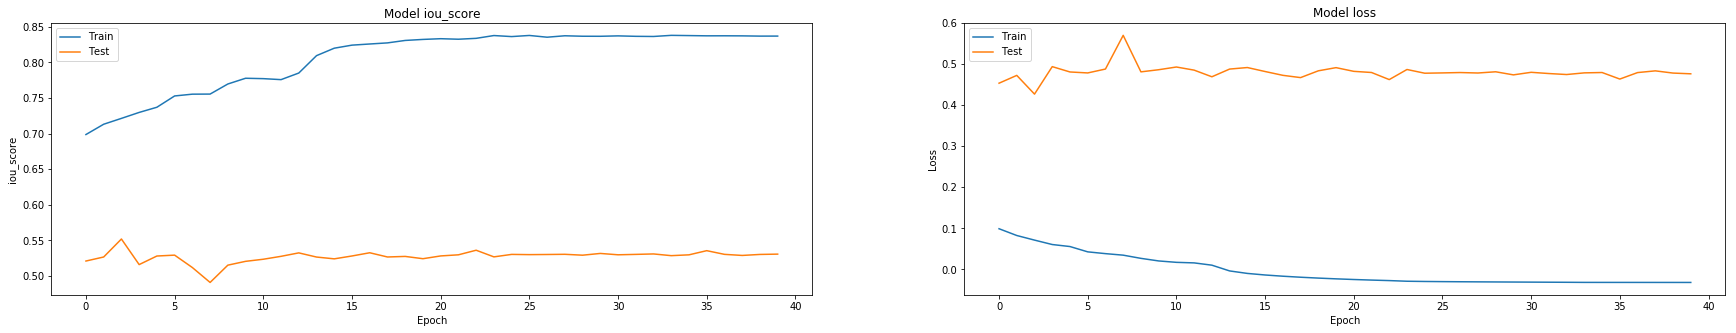

In [55]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
./

SyntaxError: invalid syntax (<ipython-input-18-f87512eb5e8b>, line 1)

# Model Evaluation

In [56]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=50, shuffle=False)
# assert test_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
# assert test_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)


In [17]:
# test_dataset[1]

In [57]:
from keras.models import load_model

In [19]:
# load best weights
# model.load_weights('best_model.h5') 
checkpoint_path = "./models/multiResUnet_mw_1.h5"
dependencies = {"dice_loss_plus_1focal_loss":total_loss,'iou_score':sm.metrics.IOUScore(threshold=0.5), 'f1-score':sm.metrics.FScore(threshold=0.5)}
model = load_model(checkpoint_path,dependencies)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [58]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.41418
mean iou_score: 0.46997
mean f1-score: 0.5828


In [ ]:
------------UNet with efficientnetb1 backbone----------------------------------
'model.h5' - 

# Visualization of results on test dataset

In [ ]:
# len(test_dataset)

In [59]:
n = 200
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
image_all = []
gt_mask_all = []
pr_mask_all = []
for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
#     print(pr_mask.shape)
    image_all.append(image[0])
    gt_mask_all.append(gt_mask)
    pr_mask_all.append(pr_mask[0])
#     visualize(
#         image=denormalize(image.squeeze()),
#         gt_mask=gt_mask.squeeze(),
#         pr_mask=pr_mask.squeeze(),
#     )

## TESTING 

In [60]:
image_all = np.array(image_all)
gt_mask_all = np.array(gt_mask_all)
pr_mask_all = np.array(pr_mask_all)

In [61]:
gt_mask_all = np.where(gt_mask_all>0, 127, 0)
pr_mask_all = np.where(pr_mask_all>0.5, 127, 0)

In [62]:
print(gt_mask_all.shape)
print(pr_mask_all.shape)

(200, 256, 256, 3)
(200, 256, 256, 3)


In [63]:
## Remove Blank patches
image_all1 = []
gt_mask_all1 = []
pr_mask_all1 = []
for i in range(len(gt_mask_all)):
    if np.sum(gt_mask_all[i,:,:,1:]) > 0:
        gt_mask_all1.append(gt_mask_all[i])
        pr_mask_all1.append(pr_mask_all[i])
        image_all1.append(image_all[i])
gt_mask_all = np.array(gt_mask_all1)
pr_mask_all = np.array(pr_mask_all1)
image_all = np.array(image_all1)

In [64]:
# plt.imshow(gt_mask_all[0,:,:])

In [65]:
print(gt_mask_all.shape)
print(pr_mask_all.shape)

(200, 256, 256, 3)
(200, 256, 256, 3)


In [66]:
gt_mask_all = gt_mask_all.astype('uint8')
pr_mask_all = pr_mask_all.astype('uint8')

In [67]:
def dice_coef(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

from keras import backend as K
def iou_coef(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [68]:
## Class wise Dice Score
dice = np.zeros((gt_mask_all.shape[-1]))
iou = np.zeros((gt_mask_all.shape[-1]))
for i in range(0,gt_mask_all.shape[-1]):
    dice[i] = dice_coef(gt_mask_all[:,:,:,i],pr_mask_all[:,:,:,i])
    iou[i] = iou_coef(gt_mask_all[:,:,:,i],pr_mask_all[:,:,:,i])

In [69]:
print(dice)
print(iou)

[0.95105824 0.41002457 0.43415226]
[0.90668355 0.25788107 0.27726339]


In [70]:
image_all.shape

(200, 256, 256, 3)

In [71]:
def overlay_mask(image,mask):
    img = image.copy()
    c_1 = 0
    c_2 = 0
    c_3 = 0
    c_4 = 0
    cent = []
    for i in range(1,mask.shape[-1]):
        # src = cv2.imread(cv2.samples.findFile(args.input))
        src = mask[:,:,i:i+1].copy()
        src = np.concatenate((src,src,src),axis=-1)
        src[np.all(src == 255, axis=2)] = 0.4
#         plt.imshow(src)
#         plt.show()
        kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
        # do the laplacian filtering as it 

        # well, we need to convert everything in something more deeper then CV_8U
        # because the kernel has some negative values,
        # and we can expect in general to have a Laplacian image with negative values
        # BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
        # so the possible negative number will be truncated

        imgLaplacian = cv2.filter2D(src, cv2.CV_32F, kernel)
        sharp = np.float32(src)
        imgResult = sharp - imgLaplacian
        # convert back to 8bits gray scale
        imgResult = np.clip(imgResult, 0, 255)
        imgResult = imgResult.astype('uint8')
        imgLaplacian = np.clip(imgLaplacian, 0, 255)
        imgLaplacian = np.uint8(imgLaplacian)
        #cv2.imshow('Laplace Filtered Image', imgLaplacian)
#         plt.imshow(imgResult)
#         plt.show()

        bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)
        _, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#         plt.imshow(bw,'gray')
#         plt.show()

        dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
        # Normalize the distance image for range = {0.0, 1.0}
        # so we can visualize and threshold it
        cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
#         plt.imshow(dist)
#         plt.show()

        _, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
        # Dilate a bit the dist image
        kernel1 = np.ones((3,3), dtype=np.uint8)
        dist = cv2.dilate(dist, kernel1)
#         plt.imshow(dist)
#         plt.show()

        dist_8u = dist.astype('uint8')
        # Find total markers
        contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in contours:
            ((x, y), _) = cv2.minEnclosingCircle(c)
            cent.append((int(x),int(y),i))

        if i==1:
            c_1 = c_1 + len(contours)
            color = [255,0,0]
        elif i ==2:
            c_2 = c_2 + len(contours)
            color = [0,0,255]
        elif i==3:
            c_3 = c_3 + len(contours)
            color = [0,255,0]
        elif i==4:
            c_4 = c_4 + len(contours)
            color = [255,255,255]
        # Draw contours on the image
        cv2.drawContours(img, contours, -1, color, 2) 
    cent = np.array(cent)
    return img, (c_1,c_2,c_3,c_4), cent


In [72]:
def improve_pred(image, pred_centroids):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_brown = np.array([0, 20, 10])
    upper_brown = np.array([50, 200, 210])

    img_p = cv2.inRange(hsv_img, lower_brown, upper_brown)
    kernel = np.ones((5,5),np.uint8)
    mask_pos = cv2.dilate(img_p,kernel=None,iterations = 2)
#     plt.imshow(erd,'gray')
#     centroids = []
    for j,i in enumerate(pred_centroids):
#         print(j,i)
        if (mask_pos[i[1],i[0]]>0) and i[2]==4:
            pred_centroids[j,2] = 3
#         elif (mask_pos[i[1],i[0]]==0) and i[2]==3:
#             pred_centroids[j,2] = 4
    
    return pred_centroids

In [73]:
## Compute TPR/FPR
def compute_metric(image, og_mask, gt_centroids, pred_centroids):
    tp = np.zeros(og_mask.shape[-1])
    fn = np.zeros(og_mask.shape[-1])
    fp = np.zeros(og_mask.shape[-1])
    tn = np.zeros(og_mask.shape[-1])
    tpr = np.zeros(og_mask.shape[-1])
    for i in pred_centroids:
#         for j in range(1,og_mask.shape[-1]):
        if og_mask[i[1],i[0],i[2]] > 0:
            tp[i[2]] = tp[i[2]] + 1
        else:
            fp[i[2]] = fp[i[2]] + 1

    for i in range(1,og_mask.shape[-1]):
#         if len(gt_centroids)>0:
        fn[i] = len(np.where(gt_centroids[:,2]==i)[0]) - tp[i]
#         else:
#             fn[i] = 0 - tp[i]
        tpr[i] = tp[i]/(tp[i]+fn[i])
    
    return tp, fp, fn
#             elif
#                 fp = fp + 1

In [74]:
channels = 3
tp_all = np.zeros(channels)
fn_all = np.zeros(channels)
fp_all = np.zeros(channels)
recall = np.zeros(channels)
precision = np.zeros(channels)
fscore = np.zeros(channels)

for i in range(image_all.shape[0]):
    x, count, gt_centroids = overlay_mask(image_all[i],gt_mask_all[i])
    y, count, pred_centroids = overlay_mask(image_all[i],pr_mask_all[i])
#     pred_centroids = improve_pred(image[i],pred_centroids)
#     if len(gt_centroids)>0:
    tp, fp, fn = compute_metric(image_all[i],gt_mask_all[i],gt_centroids,pred_centroids)
    tp_all+=tp
    fp_all+=fp
    fn_all+=fn
    
for i in range(1,gt_mask_all.shape[-1]):
    recall[i] = tp_all[i]/(tp_all[i]+fn_all[i])
    precision[i] = tp_all[i]/(tp_all[i]+fp_all[i])
    fscore[i] = 2*((precision[i]*recall[i])/(precision[i]+recall[i]))

print('Precision: ', precision)
print('Recall:    ', recall)
print('Fscore:    ', fscore)

/home/ritesh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Precision:  [0.         0.56193896 0.72502806]
Recall:     [0.         0.45494186 0.41172721]
Fscore:     [0.         0.50281124 0.52520325]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

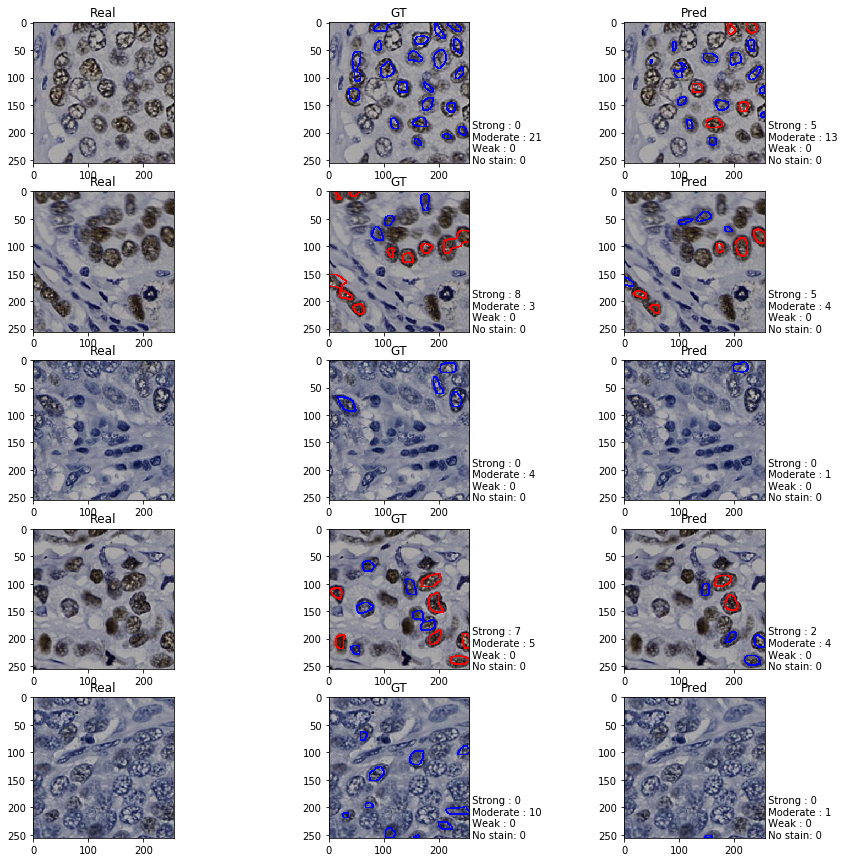

In [76]:
fig = plt.figure(figsize=(15,15))
x = [1,4,7,10,13]
j = 1
for i in x:
    
    img_x, count_x, centroids_x = overlay_mask(image_all[j],gt_mask_all[j])
    img_y, count_y, centroids_y = overlay_mask(image_all[j],pr_mask_all[j])

    a = fig.add_subplot(5, 3, i)
    imgplot = plt.imshow(image_all[j])
    a.set_title('Real')
    a = fig.add_subplot(5, 3, i+1)
    imgplot = plt.imshow(img_x)
    a.set_title('GT')
    a.text(256,256,' Strong : '+str(count_x[0])+'\n Moderate : '+str(count_x[1])+
           '\n Weak : '+str(count_x[2])+'\n No stain: '+str(count_x[3]),fontsize=10)
    a = fig.add_subplot(5, 3, i+2)
    imgplot = plt.imshow(img_y)
    a.set_title('Pred')
    a.text(256,256,' Strong : '+str(count_y[0])+'\n Moderate : '+str(count_y[1])+
           '\n Weak : '+str(count_y[2])+'\n No stain: '+str(count_y[3]),fontsize=10)
    
    j = j+10
# fig.suptitle('Model 14'+'\nDice : '+str(ds)+'\nIoU : '+str(iou),size=12)
# fig.tight_layout()
# fig.subplots_adjust(top=1)
